An example of generating a population of objects and then using the UserPointSlicer to see how well observed each one is.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic

/Users/yoachim/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First we need a function to generate a lightcurve that takes as input the times the lightcurve is observed, and then parameters that descibe the shape of the lightcurve.

In [2]:
def toyObjectLC(t, t0, a, b, duration=10.):
    """
    Makes a transient object lightcurve that has an instantaneous appearance followed by a 
    linear rise or decline and then an instantaneous disappearance.

    Parameters
    ----------
    t : np.array
        Array of observation times (days)
    t0 : float
        The peak time (days)
    a : float
        Peak brightness (mags)
    b : float
        Slope of the lightcurve (mags/day). Negative values of b result in 
        a brightening object
    duration : float (10)
        Time between appearance and disappearance (days)
        
    Returns
    -------
    lightcurve : np.array
        1-D array of magnitudes to match t
        
    Notes
    -----
    Objects could be given colors by setting different parameters per filter. For now 
    this is assumed to be a flat SED source.
        
    """
    good = np.where( (t >= t0) & (t <= t0+duration) )
    lightcurve = np.zeros(np.size(t), dtype=float)
    lightcurve[good] = a + b*(t[good]-t0)
    return lightcurve


We need a metric that can quantify the degree to which a lightcurve has been "well observed". For this example, we will say that any lightcurve that is observed to be above the 5-sigma limiting depth twice in any filter is "well-observed".

In [3]:
class DetectToymetric(metrics.BaseMetric):
    def __init__(self, metricName='detectToymetric', mjdCol='expMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', nightCol='night', ptsNeeded=2, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded
        super(DetectToymetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol, nightCol],
                                              units='Detected',
                                              metricName=metricName, **kwargs)
        
    def run(self,  dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        lightcurve = toyObjectLC(dataSlice[self.nightCol], slicePoint['t0'], slicePoint['a'], slicePoint['b'])
        # Check if there are enough points detected in the generated lightcurve
        npts = np.where( (lightcurve != 0.) & (lightcurve < dataSlice[self.m5Col]))[0].size
        if npts >= self.ptsNeeded:
            return 1
        else:
            return 0

Let's model our population of transient objects so that we can check to see if they are "well observed".  

We will model each object as having a position given by RA,dec, an explosion time of t0, and light curve shape parameters a and b

In [4]:
# The fields for our transient catalog
names = ['ra', 'dec', 't0', 'a', 'b']
# Number of objects to create
nobjs = 1e3  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
# An empty numpy array that will hold the catalog of transient objects
transObjects = np.zeros(nobjs, dtype=zip(names, [float]*len(names)))
# Concentrate objects in the galactic plane
l = np.random.rand(nobjs)*360.
b = np.random.randn(nobjs)*20.
transObjects['ra'], transObjects['dec'] = equatorialFromGalactic(l,b) 
# Generate lightcurve parameters 
transObjects['t0'] = np.random.rand(nobjs)*365.25*10
transObjects['a'] = np.random.rand(nobjs)*3+20.
transObjects['b'] = np.random.rand(nobjs)

using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future


In [5]:
# Set up the slicer
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'])
# Add any additional information about each object to the slicer
slicer.slicePoints['t0'] = transObjects['t0']
slicer.slicePoints['a'] = transObjects['a']
slicer.slicePoints['b'] = transObjects['b']

In [6]:
runName = 'enigma_1189'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'TransientsUPS'
resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
metric = DetectToymetric()
sql = ''
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)


In [8]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with no constraint.
Found 2469307 visits
Running:  ['enigma_1189_detectToymetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with  constraint now.
Plotting complete.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
Optimal bin calculation tried to make inf bins, returning 200


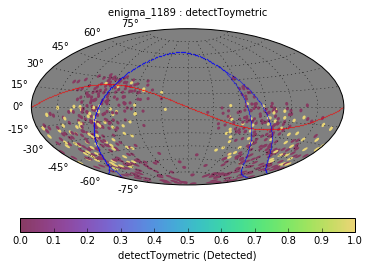

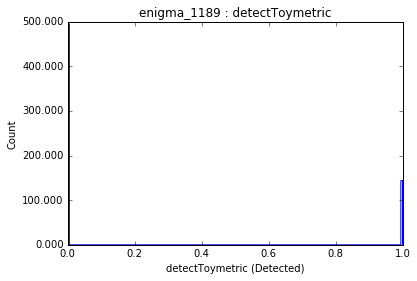

In [9]:
bgroup.plotAll(closefigs=False)

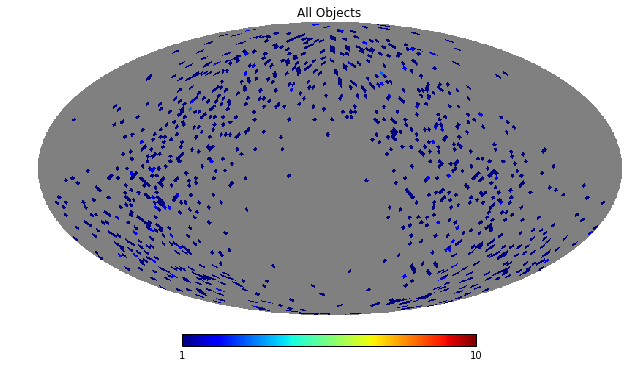

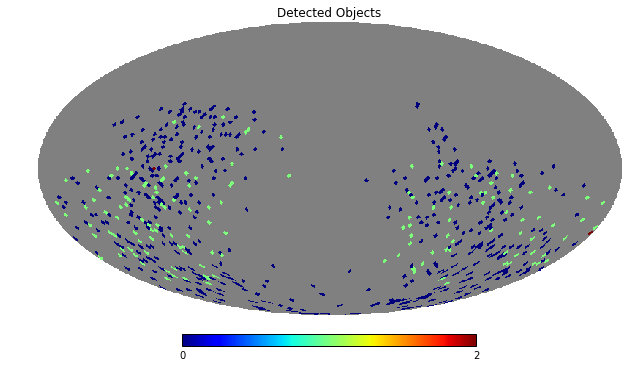

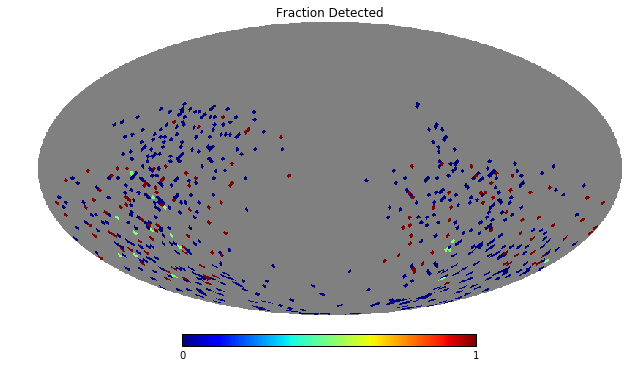

In [10]:
# Not the best plot, let's look at some fractions
from lsst.sims.utils import healbin
import healpy as hp
nside = 32
allObjects = healbin(transObjects['ra'], transObjects['dec'], transObjects['ra']*0+1, nside=nside, reduceFunc=np.sum)
detectedObjects = healbin(transObjects['ra'], transObjects['dec'],bundle.metricValues, nside=nside, reduceFunc=np.sum)
hp.mollview(allObjects, title='All Objects', max=10)
hp.mollview(detectedObjects, title='Detected Objects')
frac = detectedObjects/allObjects
frac[np.where((allObjects == 0) | (detectedObjects == hp.UNSEEN))] = hp.UNSEEN
hp.mollview(frac, title='Fraction Detected')


In [11]:
print 'Fraction of Toy objects detected = %f' % (np.sum(bundle.metricValues)/nobjs)

Fraction of Toy objects detected = 0.144000
